<div style="width: 100%; clear: both;">
<div style="float: left; width: 50%;">
<img src="http://www.uoc.edu/portal/_resources/common/imatges/marca_UOC/UOC_Masterbrand.jpg", align="left">
</div>
<div style="float: right; width: 50%;">
<p style="margin: 0; padding-top: 22px; text-align:right;">M2.855 ¬∑ Modelos avanzados de miner√≠a de datos ¬∑ PEC3</p>
<p style="margin: 0; text-align:right;">2020-2 ¬∑ M√°ster universitario en Ciencia de datos (<i>Data science</i>)</p>
<p style="margin: 0; text-align:right; padding-button: 100px;">Estudios de Inform√°tica, Multimedia y Telecomunicaci√≥n</p>
</div>
</div>
<div style="width:100%;">&nbsp;</div>


# PEC 3: M√©todos supervisados

En esta pr√°ctica veremos diferentes m√©todos supervisados y trataremos de optimizar diferentes m√©tricas. Veremos como los diferentes modelos clasifican los puntos y con cuales obtenemos mayor precisi√≥n. Despu√©s aplicaremos todo lo que hemos aprendido hasta ahora a un dataset nuevo simulando un caso pr√°ctico real.

1. Exploraci√≥n de algoritmos supervisados
    1. Naive-Bayes
    2. $k$ vecinos m√°s pr√≥ximos
    3. Support vector machines
    4. √Årboles de decisi√≥n
    5. Random forest / Gradient boosting
2. Implementaci√≥n del caso pr√°ctico
    1. An√°lisis descriptivo
    2. Preprocesamiento de los datos
    3. Entrenamiento del modelo
    4. Predicci√≥n de nuevos casos

**Importante: Cada uno de los ejercicios puede suponer varios minutos de ejecuci√≥n, por lo que la entrega se har√° en formato notebook y en formato html donde se vea el c√≥digo y los resultados, junto con los comentarios de cada ejercicio. Para exportar el notebook a html se puede hacer desde el men√∫ File $\to$ Download as $\to$ HTML.**

In [1]:
import numpy as np 
import pandas as pd
import seaborn as sns

from sklearn import datasets
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.model_selection import train_test_split, GridSearchCV,cross_val_score
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import OneHotEncoder
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier, export_graphviz
from sklearn.utils import check_random_state
import numpy.random as nr

# Visualizar √°rboles
from IPython.display import Image
import pydotplus
from six import StringIO

# UMAP para la reducci√≥n de dimensionalidad
import umap

# Visualizaci√≥n
from matplotlib.colors import ListedColormap
import matplotlib.pyplot as plt

%matplotlib inline

## 1. Exploraci√≥n de algoritmos supervisados (5 puntos)

En la PEC anterior trabajamos con el dataset MNIST, compuesto de miles de d√≠gitos manuscritos del 0 al 9. Donde cada imagen se compone de 784 p√≠xeles (im√°genes de 28 x 28). Redujimos a dos dimensiones el dataset utilizando diferentes t√©cnicas de clustering, y vimos que con UMAP consegu√≠amos separar las clases (d√≠gitos) bastante bien en 2D.

En este primer ejercicio iremos un paso m√°s all√°, utilizaremos diferentes m√©todos supervisados para predecir las diferentes clases. El objetivo ser√° que, dada una imagen nueva, el algoritmo sea capaz de clasificar correctamente el n√∫mero de la imagen.

Empezamos cargando el dataset y visualizando un ejemplo de cada d√≠gito.

In [2]:
X, y = datasets.fetch_openml('mnist_784', version=1, return_X_y=True, as_frame=False)
random_state = check_random_state(0)
permutation = random_state.permutation(X.shape[0])
X = X[permutation]
y = y[permutation].astype(int)
X = X.reshape((X.shape[0], -1))

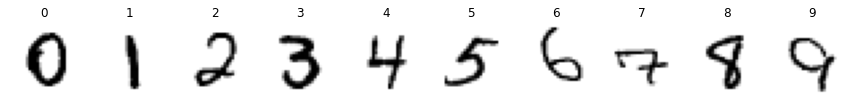

In [3]:
fig, axis = plt.subplots(1, 10, figsize=(12, 6))
for i, ax in zip(range(10), axis):
    ax.imshow(X[y == i][0].reshape(28, 28), cmap='gray_r')
    ax.set_title(str(i))
    ax.axis('off')
plt.tight_layout()

Este dataset es muy grande, con una muestra obtendremos resultados muy similares y nos permitir√° trabajar con m√°s agilidad.

In [4]:
all_data = pd.DataFrame(X)
all_data['y'] = y

sample_data = all_data.sample(frac = 0.1, random_state=24)
X = sample_data.drop(columns=['y'])
y = sample_data['y']

print(all_data.shape)
print(sample_data.shape)

(70000, 785)
(7000, 785)


<div style="background-color: #EDF7FF; border-color: #7C9DBF; border-left: 5px solid #7C9DBF; padding: 0.5em;">
    <strong>Implementaci√≥n:</strong> 
</div>

Dividid el _dataset_ en dos subconjuntos, __*train*__ (80% de los datos) y __*test*__ (20% de los datos). Nombrad los conjuntos como: X_train, X_test, y_train, y_test. Utilizad la opci√≥n `random_state = 24`.
    
Pod√©is utilizar la implementaci√≥n `train_test_split` de `sklearn`.

In [5]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=24)

Para poder visualizar los resultados de cada algoritmo supervisado, reduciremos el dataset anterior a dos dimensiones, tal como hicimos en la PEC2.

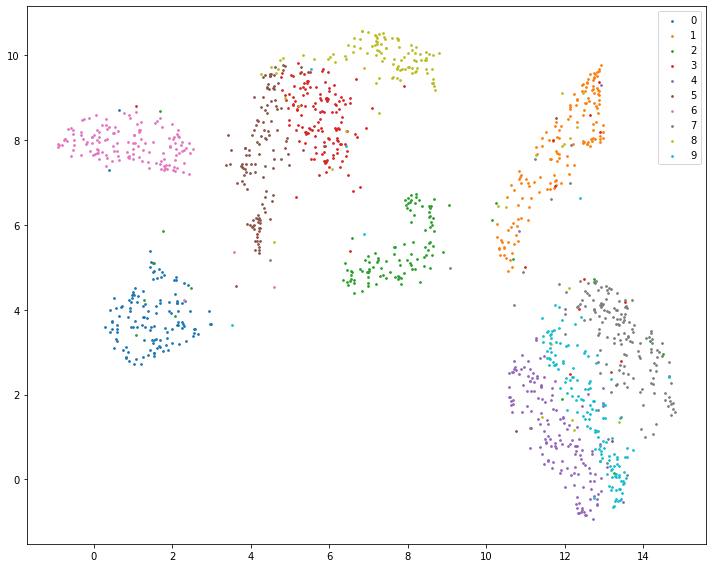

In [6]:
model = umap.UMAP(n_components=2, random_state=42)
model.fit(X_train)
X_train_projection = model.transform(X_train)
X_test_projection = model.transform(X_test)

fig, ax = plt.subplots(1, 1, figsize=(10, 8))
for i in range(10):
    ax.scatter(X_test_projection[y_test == i,0], X_test_projection[y_test == i,1], s=3, label=str(i))
plt.legend()
plt.tight_layout()

A lo largo de los ejercicios aprenderemos a ver gr√°ficamente las fronteras de decisi√≥n que nos devuelven los diferentes modelos. Para ello utilizaremos la funci√≥n definida a continuaci√≥n, que sigue los siguientes pasos:

   - Crear una _meshgrid_ con los valores m√≠nimo y m√°ximo de 'x' e 'y'.
   - Predecir el clasificador con los valores de la _meshgrid_.
   - Hacer un _reshape_ de los datos para tener el formato correspondiente.
  
Una vez hecho esto, ya podemos hacer el gr√°fico de las fronteras de decisi√≥n y a√±adir los puntos reales. As√≠ veremos las √°reas que el modelo considera que son de una clase y las que considera que son de otra. Al poner encima los puntos veremos si los clasifica correctamente en el √°rea que les corresponde.

In [7]:
# vamos a crear la meshgrid con los valores m√≠nimos y m√°ximos de los ejes x e y
x_min, x_max = X_test_projection[:, 0].min() - 1, X_test_projection[:, 0].max() + 1
y_min, y_max = X_test_projection[:, 1].min() - 1, X_test_projection[:, 1].max() + 1
    
# definimos la funci√≥n que visualizar√° la frontera de decisi√≥n
def plot_decision_boundaries(model, X_test_projection, y_test):
    
    xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.05),
                         np.arange(y_min, y_max, 0.05))
    
    # precedimos con el clasificador con los valores de la meshgrid
    Z = model.predict(np.c_[xx.ravel(), yy.ravel()])

    # definimos los colores (uno para cada clase)
    cmap_light = ListedColormap(['gainsboro','lightgreen','peachpuff','lightcyan', 'pink',
                                 'lightyellow','lavender','lightcoral', 'lightskyblue', 'aquamarine'])
    cmap_bold = ['grey','g','sandybrown','c','palevioletred', 
                 'y','mediumpurple','firebrick', 'dodgerblue', 'mediumaquamarine']
    
    # dibujamos las fronteras
    Z = Z.reshape(xx.shape)
    plt.figure(figsize=(20,10))
    plt.pcolormesh(xx, yy, Z, cmap=cmap_light)

    # dibujamos los puntos
    for i in range(10):
        plt.scatter(X_test_projection[y_test == i,0], X_test_projection[y_test == i,1], 
                    s=3, label=str(i), c=cmap_bold[i])
    plt.legend()
    plt.xlim(xx.min(), xx.max())
    plt.ylim(yy.min(), yy.max())    

### 1.1. Gaussian Na√Øve Bayes

El objetivo de este primer ejercicio es entender el funcionamiento del algoritmo Na√Øve-Bayes, un algoritmo peculiar ya que se basa completamente en teor√≠a de probabilidades.

<div style="background-color: #EDF7FF; border-color: #7C9DBF; border-left: 5px solid #7C9DBF; padding: 0.5em;">
<strong>Implementaci√≥n:</strong> 
</div>

Con el dataset de _train_ reducido a dos dimensiones, entrenad un modelo Na√Øve-Bayes y representad gr√°ficamente la frontera de decisi√≥n con el de _test_. Pod√©is utilizar el clasificador **GaussianNB** de `sklearn`.
    
Calculad el _accuracy_ del modelo obtenido sobre _train_ y _test_ y la matriz de confusi√≥n sobre _test_. Pod√©is utilizar `accuracy_score` y `confusion_matrix` del paquet `metrics` de `sklearn`.

In [8]:
clf_GNB = GaussianNB()
clf_GNB.fit(X_train_projection, y_train)

GaussianNB()

<ipython-input-7-53494ca68afb>:23: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  plt.pcolormesh(xx, yy, Z, cmap=cmap_light)


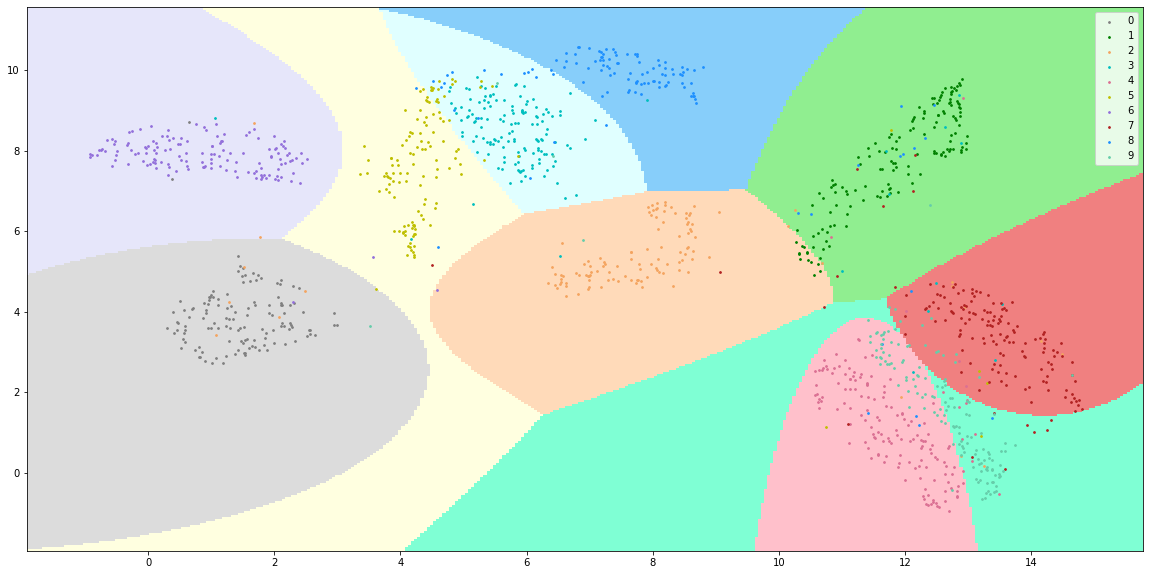

In [9]:
plot_decision_boundaries(clf_GNB, X_test_projection, y_test)

In [10]:
y_pred = clf_GNB.predict(X_test_projection)
accuracy_score(y_test, y_pred)

0.8435714285714285

In [11]:
confusion_matrix(y_test, y_pred)

array([[127,   0,   0,   0,   0,   0,   2,   0,   0,   0],
       [  0, 135,  13,   0,   0,   0,   0,   0,   0,   0],
       [  5,   3, 103,   0,   1,   0,   2,   5,   0,   2],
       [  0,   6,   1, 138,   1,   2,   1,   4,   1,   0],
       [  0,   2,   0,   0, 142,   0,   0,   3,   0,   9],
       [  1,   1,   0,  21,   1, 101,   0,   2,   0,   1],
       [  1,   0,   1,   0,   0,   1, 142,   0,   0,   0],
       [  0,   6,   1,   0,   1,   1,   0, 135,   0,   8],
       [  0,   9,   0,  17,   4,   2,   0,   1,  86,   1],
       [  1,   1,   1,   2,  54,   0,   0,  16,   0,  72]])

<div style="background-color: #EDF7FF; border-color: #7C9DBF; border-left: 5px solid #7C9DBF; padding: 0.5em;">
<strong>An√°lisis:</strong> 
</div>
  
An√°lisis del ejercicio.

   - ¬øC√≥mo son las fronteras de decisi√≥n? ¬øTiene sentido que tengan esta forma con el algoritmo utilizado?
   - ¬øC√≥mo son las predicciones obtenidas sobre el conjunto de test?

### 1.2. KNN

El objetivo de este segundo ejercicio es entender el funcionamiento del KNN, intuir sus principales ventajas o desventajas y entender la influencia de los par√°metros de los que est√° compuesto.

K-Nearest-Neighbor es un algoritmo basado en instancia de tipo supervisado. 

Vamos a ver qu√© significa esto:

  - Supervisado: tenemos etiquetado nuestro conjunto de datos de entrenamiento, con la clase o resultado esperado.
  - Basado en instancia (_Lazy Learning_): Esto significa que nuestro algoritmo no aprende expl√≠citamente un modelo (como por ejemplo en Regresi√≥n Log√≠stica o √°rboles de decisi√≥n), sino que memoriza las instancias de entrenamiento que son utilizadas como "conocimiento" para la fase de predicci√≥n.

¬øC√≥mo funciona KNN?

  - Calculamos la distancia entre el √≠tem a clasificar y los dem√°s √≠tems del dataset de entrenamiento.
  - Seleccionamos los "k" elementos m√°s cercanos, es decir, con menor distancia, seg√∫n la distancia que utilizamos (eucl√≠dea, coseno, manhattan, etc).
  - Por √∫ltimo realizamos una "votaci√≥n de mayor√≠a" entre los k puntos: los de la clase que "dominan" decidir√°n su clasificaci√≥n final.

<div style="background-color: #EDF7FF; border-color: #7C9DBF; border-left: 5px solid #7C9DBF; padding: 0.5em;">
<strong>Implementaci√≥n:</strong>
</div>

Con el dataset de _train_ reducido a dos dimensiones, entrenad un modelo KNN con `n_neighbors = 2` y representad gr√°ficamente la frontera de decisi√≥n con el de _test_.
    
Pod√©is utilizar el clasificador **KNeighborsClassifier** de `sklearn`.

In [12]:
clf_KNN = KNeighborsClassifier(n_neighbors=2)
clf_KNN.fit(X_train_projection, y_train)

KNeighborsClassifier(n_neighbors=2)

<ipython-input-7-53494ca68afb>:23: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  plt.pcolormesh(xx, yy, Z, cmap=cmap_light)


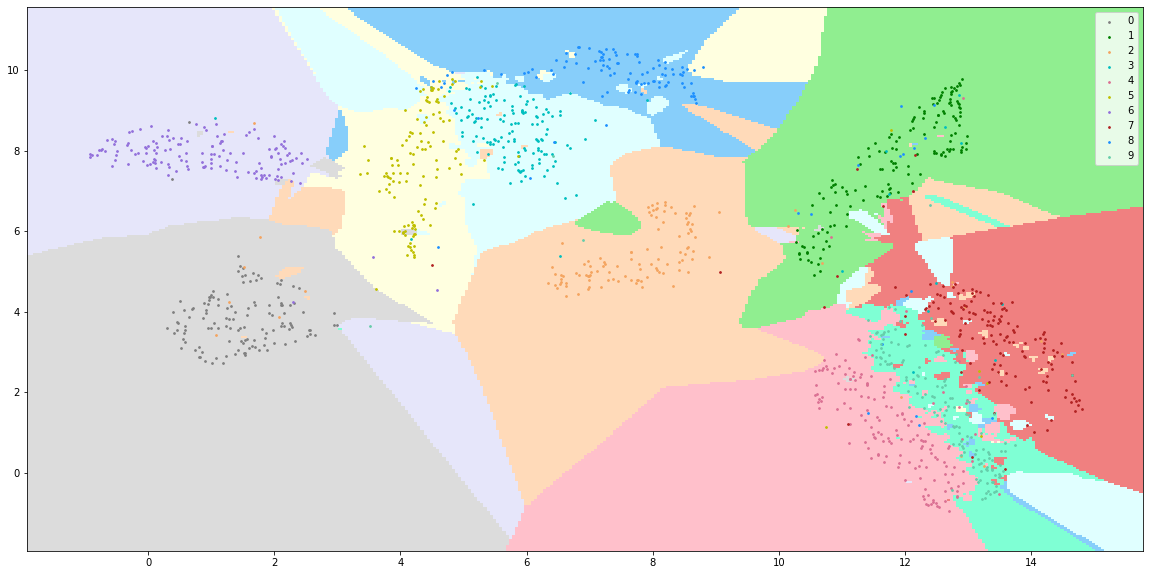

In [13]:
plot_decision_boundaries(clf_KNN, X_test_projection, y_test)

En el modelo entrenado, hemos fijado el par√°metro `n_neighbors` de forma arbitraria. Pero podr√≠a ser que con otro valor obtuvi√©ramos una mejor predicci√≥n.

Para conocer el valor √≥ptimo de los par√°metros de un modelo (_hyperparameter tunning_) se suele utilizar una b√∫squeda de rejilla (_grid search_). Es decir, entrenar un modelo para cada combinaci√≥n de hiperpar√°metros posible y evaluarlo utilizando validaci√≥n cruzada (_cross validation_) con 4 particiones estratificadas. Posteriormente, se elige la combinaci√≥n de hiperpar√†metres que mejores resultados haya obtenido.

En este caso s√≥lo queremos optimizar un hiperpar√°metro:

   - ùëò: el n√∫mero de vecinos que se consideran para clasificar un nuevo ejemplo. Probaremos con todos los valores entre 1 y 10.

<div style="background-color: #EDF7FF; border-color: #7C9DBF; border-left: 5px solid #7C9DBF; padding: 0.5em;">
    <strong>Implementaci√≥n:</strong>
</div>

C√°lculo del valor √≥ptimo del hiperpar√°metro _k_ (`n_neighbors`). Utilizad una b√∫squeda de rejilla con validaci√≥n cruzada para encontrar el valor √≥ptimo de _k_. Por cada valor, calculad su promedio y la desviaci√≥n est√°ndar. Implementad un _heatmap_ para visualizar la precisi√≥n seg√∫n los diferentes valores del hiperpar√°metro.
    
Puede utilizar el m√≥dulo `GridSearchCV` de `sklearn` el c√°lculo del mejor hiperpar√°metro, y `heatmap` de `Seaborn`.

In [14]:
grid_params = {'n_neighbors': list(range(1, 11))}

gs_KNN = GridSearchCV(
        KNeighborsClassifier(),
        grid_params,
        scoring='accuracy',
        n_jobs=-1,
        cv=4
        )
gs_KNN.fit(X_train_projection, y_train)
gs_KNN.best_estimator_

KNeighborsClassifier(n_neighbors=10)

In [15]:
print('Mean test score by n_neighbors')
for i, x in enumerate(gs_KNN.cv_results_['mean_test_score']):
    print('n_neighbors = %2d    %4.3f' % (i+1, x))

Mean test score by n_neighbors
n_neighbors =  1    0.897
n_neighbors =  2    0.901
n_neighbors =  3    0.928
n_neighbors =  4    0.930
n_neighbors =  5    0.931
n_neighbors =  6    0.930
n_neighbors =  7    0.929
n_neighbors =  8    0.931
n_neighbors =  9    0.931
n_neighbors = 10    0.932


In [16]:
print('Std test score by n_neighbors')
for i, x in enumerate(gs_KNN.cv_results_['std_test_score']):
    print('n_neighbors = %2d    %4.3f' % (i+1, x))

Std test score by n_neighbors
n_neighbors =  1    0.002
n_neighbors =  2    0.003
n_neighbors =  3    0.007
n_neighbors =  4    0.007
n_neighbors =  5    0.006
n_neighbors =  6    0.006
n_neighbors =  7    0.008
n_neighbors =  8    0.006
n_neighbors =  9    0.007
n_neighbors = 10    0.007


<AxesSubplot:xlabel='param_n_neighbors'>

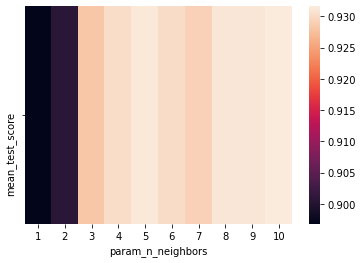

In [17]:
pvt = pd.pivot_table(pd.DataFrame(gs_KNN.cv_results_),
        values='mean_test_score', columns='param_n_neighbors')
sns.heatmap(pvt)

<div style="background-color: #EDF7FF; border-color: #7C9DBF; border-left: 5px solid #7C9DBF; padding: 0.5em;">
<strong>Implementaci√≥n:</strong>
</div>

Con el mejor hiperpar√°metro encontrado, volved a entrenar un clasificador KNN (con _train_) y representar las fronteras de decisi√≥n con los puntos de _test_.
    
Calcular el _accuracy_ del modelo obtenido sobre _test_ y la matriz de confusi√≥n. Pod√©is utilizar `accuracy_score` y `confusion_matrix` de `metrics` de `sklearn`.

In [18]:
gs_KNN.best_estimator_.n_neighbors

10

In [19]:
clf_KNN = KNeighborsClassifier(n_neighbors=gs_KNN.best_estimator_.n_neighbors)
clf_KNN.fit(X_train_projection, y_train)

KNeighborsClassifier(n_neighbors=10)

<ipython-input-7-53494ca68afb>:23: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  plt.pcolormesh(xx, yy, Z, cmap=cmap_light)


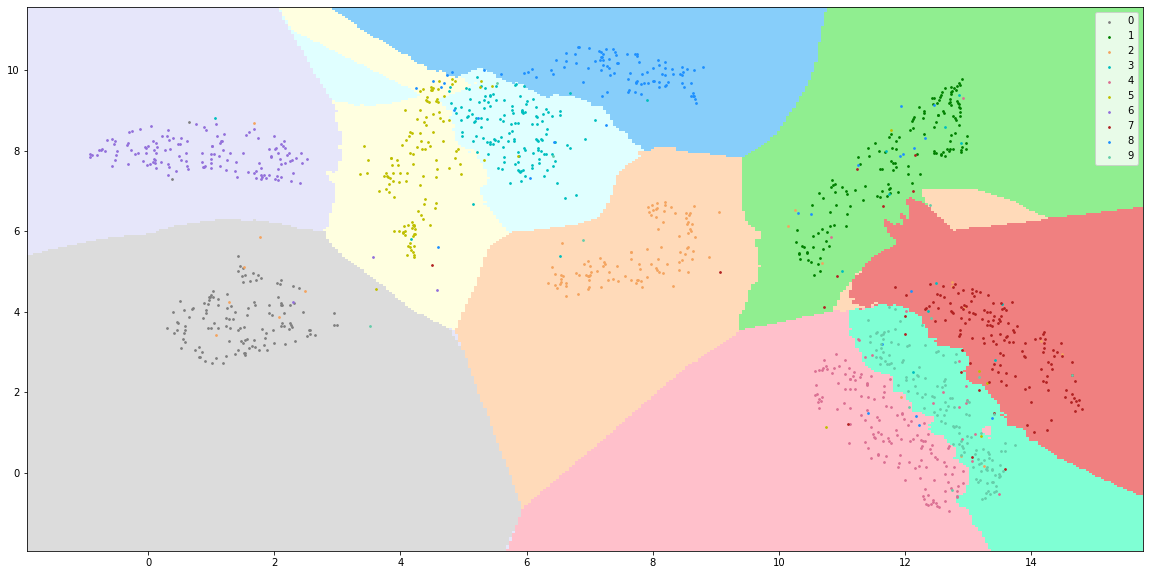

In [20]:
plot_decision_boundaries(clf_KNN, X_test_projection, y_test)

In [21]:
y_pred = clf_KNN.predict(X_test_projection)
accuracy_score(y_test, y_pred)

0.9078571428571428

In [22]:
confusion_matrix(y_test, y_pred)

array([[127,   0,   0,   0,   0,   0,   2,   0,   0,   0],
       [  0, 148,   0,   0,   0,   0,   0,   0,   0,   0],
       [  6,   3, 103,   0,   1,   0,   1,   5,   0,   2],
       [  0,   6,   1, 131,   0,   6,   1,   4,   4,   1],
       [  0,   2,   0,   0, 136,   0,   0,   0,   0,  18],
       [  1,   1,   0,   5,   1, 117,   0,   2,   0,   1],
       [  1,   0,   0,   0,   0,   2, 142,   0,   0,   0],
       [  0,   6,   1,   0,   1,   1,   0, 136,   0,   7],
       [  0,   9,   0,   6,   3,   5,   0,   1,  94,   2],
       [  1,   0,   2,   2,   2,   0,   0,   3,   0, 137]])

<div style="background-color: #EDF7FF; border-color: #7C9DBF; border-left: 5px solid #7C9DBF; padding: 0.5em;">
<strong>An√°lisis:</strong> 
</div>

An√°lisis del ejercicio:

   - Comentar los resultados de la b√∫squeda del mejor hiperpar√°metro.
   - ¬øC√≥mo se visualiza gr√°ficamente el cambio del valor `n_neighbors`? ¬øTiene sentido esta diferencia entre los dos gr√°ficos al cambiar el par√°metro?
   - ¬øC√≥mo son las fronteras de decisi√≥n? ¬øTiene sentido que tengan esta forma con el algoritmo utilizado?
   - ¬øC√≥mo son las predicciones obtenidas sobre el conjunto de test?

### 1.3. SVM

Las Support Vector Machine se fundamentan en el _M√°ximal Margin Classifier_, que a su vez, se basan en el concepto de hiperplano.

En un espacio p-dimensional, un hiperplano se define como un subespacio plano y af√≠n de dimensiones p-1. El t√©rmino af√≠n significa que el subespacio no debe pasar por el origen. En un espacio de dos dimensiones, el hiperplano es un subespacio de 1 dimensi√≥n, es decir, una recta. En un espacio tridimensional, un hiperplano es un subespacio de dos dimensiones, un plano convencional. Para dimensiones p>3 no es intuitivo visualizar un hiperplano, pero el concepto de subespacio con p-1 dimensiones se mantiene.

La definici√≥n de hiperplano para casos perfectamente separables linealmente resulta en un n√∫mero infinito de posibles hiperplanos, lo que hace necesario un m√©todo que permita seleccionar uno de ellos como clasificador √≥ptimo.

La soluci√≥n a este problema consiste en seleccionar como clasificador √≥ptimo al que se conoce como _maximal margin hyperplane_ o hiperplano √≥ptimo de separaci√≥n, que se corresponde con el hiperplano que se encuentra m√°s alejado de todas las observaciones de entrenamiento. Para obtenerlo, se debe calcular la distancia perpendicular de cada observaci√≥n a un determinado hiperplano. La menor de estas distancias (conocida como margen) determina c√≥mo de lejos est√° el hiperplano de las observaciones de entrenamiento. El _maximal margin hyperplane_ se define como el hiperplano que consigue un mayor margen, es decir, que la distancia m√≠nima entre el hiperplano y las observaciones es lo m√°s grande posible. Aunque esta idea suena razonable, no es posible aplicarla, ya que habr√≠a infinitos hiperplanos contra los que medir las distancias. En su lugar, se recurre a m√©todos de optimizaci√≥n.

El proceso de optimizaci√≥n tiene la peculiaridad de que s√≥lo las observaciones que se encuentran justo al margen o que lo violan influyen sobre el hiperplano. A estas observaciones se les conoce como vectores soporte (_vectors suport_) y son las que definen el clasificador obtenido.

#### Los _kernels_ en SVM

Hay veces en que no hay manera de encontrar un hiperplano que permita separar dos clases. En estos casos decimos que las clases no son linealmente separables. Para resolver este problema podemos utilizar el truco del n√∫cleo .

El truco del n√∫cleo (_kernel trick_) consiste en utilizar una dimensi√≥n nueva en la que podamos encontrar un hiperplano para separar las clases. Se puede ver un un ejemplo en: https://www.youtube.com/watch?v=OdlNM96sHio

Al igual que en el algoritmo visto anteriormente (KNN), las SVM tambi√©n dependen de varios hiperpar√°metros. 

En este caso intentaremos optimizar dos hiperpar√°metros:

  - C: es la regularizaci√≥n, es decir, el valor de penalizaci√≥n de los errores en la clasificaci√≥n. Indica el compromiso entre obtener el hiperplano con el margen m√°s grande posible y clasificar el m√°ximo n√∫mero de ejemplos correctamente. Probaremos los valores: 0.01, 0.1, 1, 10, 50, 100 y 200.
  
  - gama: coeficiente que multiplica la distancia entre dos puntos en el kernel radial. Para decirlo a "grosso modo", cuanto m√°s peque√±o es gama, m√°s influencia tienen dos puntos cercanos. Probaremos los valores: 0.001, 0.01, 0.1, 1 y 10.
  
Al igual que en el caso anterior, para validar el rendimiento del algoritmo con cada combinaci√≥n de hiperpar√°metros utilizaremos validaci√≥n cruzada (_cross-validation_) con 4 particiones estratificadas.

<div style="background-color: #EDF7FF; border-color: #7C9DBF; border-left: 5px solid #7C9DBF; padding: 0.5em;">
    <strong>Implementaci√≥n:</strong> 
</div>

C√°lcular del valor √≥ptimo de los hiperpar√°metros _C_ y _gama_. Utilizad una b√∫squeda de rejilla con validaci√≥n cruzada para encontrar los valores √≥ptimos. Para cada combinaci√≥n de valores, calcular su promedio y la desviaci√≥n est√°ndar. Haced un _heatmap_ para visualizar la precisi√≥n seg√∫n los diferentes valores de los hiperpar√°metros.

Pod√©is utilizar el m√≥dulo `GridSearchCV` de `sklearn` el c√°lculo de los mejores hiperpar√°metros con el clasificador SVC (de `SVM` de `sklearn`), y `heatmap` de `Seaborn`.

In [23]:
grid_params = {'C': [0.01, 0.1, 1, 10, 50, 100, 200],
              'gamma':[0.001, 0.01, 0.1, 1 , 10]}

gs_SVM = GridSearchCV(
            SVC(),
            grid_params,
            scoring='accuracy',
            n_jobs=-1,
            cv=4
            )
gs_SVM.fit(X_train_projection, y_train)
gs_SVM.best_estimator_

SVC(C=1, gamma=10)

In [24]:
gs_SVM.cv_results_['mean_test_score']

array([0.11      , 0.59375   , 0.83607143, 0.91875   , 0.11      ,
       0.59214286, 0.88892857, 0.91910714, 0.92857143, 0.93125   ,
       0.88767857, 0.91839286, 0.92589286, 0.93178571, 0.93357143,
       0.91446429, 0.92232143, 0.92875   , 0.93303571, 0.93035714,
       0.92071429, 0.92482143, 0.92946429, 0.9325    , 0.91589286,
       0.92232143, 0.92482143, 0.93035714, 0.93339286, 0.905     ,
       0.92214286, 0.925     , 0.93071429, 0.93357143, 0.89678571])

In [25]:
gs_SVM.cv_results_['std_test_score']

array([0.        , 0.00170346, 0.00469748, 0.00666959, 0.        ,
       0.00220158, 0.00598681, 0.00604775, 0.00772618, 0.00709583,
       0.00653435, 0.00589827, 0.00888382, 0.00778375, 0.00664324,
       0.00637628, 0.00763275, 0.00696886, 0.00627546, 0.00565821,
       0.00931315, 0.00899794, 0.00707783, 0.00598681, 0.00556444,
       0.00879725, 0.00965442, 0.00718736, 0.00763275, 0.00765986,
       0.00843644, 0.00978076, 0.00764319, 0.00726678, 0.0075    ])

In [26]:
pvt = pd.pivot_table(pd.DataFrame(gs_SVM.cv_results_),
    values='mean_test_score', index='param_gamma', columns='param_C')

<AxesSubplot:xlabel='param_C', ylabel='param_gamma'>

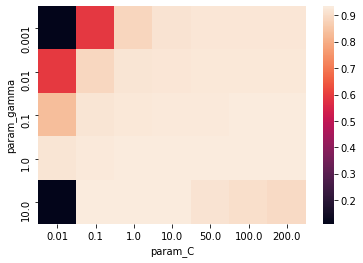

In [27]:
sns.heatmap(pvt)

<div style="background-color: #EDF7FF; border-color: #7C9DBF; border-left: 5px solid #7C9DBF; padding: 0.5em;">
<strong>Implementaci√≥n:</strong>
</div>

Con la mejor combinaci√≥n de hiperpar√°metros encuentrada, entrenad un clasificador `SVM` (con _train_) y representar las fronteras de decisi√≥n con los puntos de _test_.
    
Calcular el _accuracy_ del modelo obtenido sobre _test_ y la matriz de confusi√≥n. Puede utilizar `accuracy_score` y `confusion_matrix` de `metrics` de `sklearn`.

In [28]:
clf_SVM = SVC(C=gs_SVM.best_estimator_.C, gamma=gs_SVM.best_estimator_.gamma)
clf_SVM.fit(X_train_projection, y_train)

SVC(C=1, gamma=10)

<ipython-input-7-53494ca68afb>:23: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  plt.pcolormesh(xx, yy, Z, cmap=cmap_light)


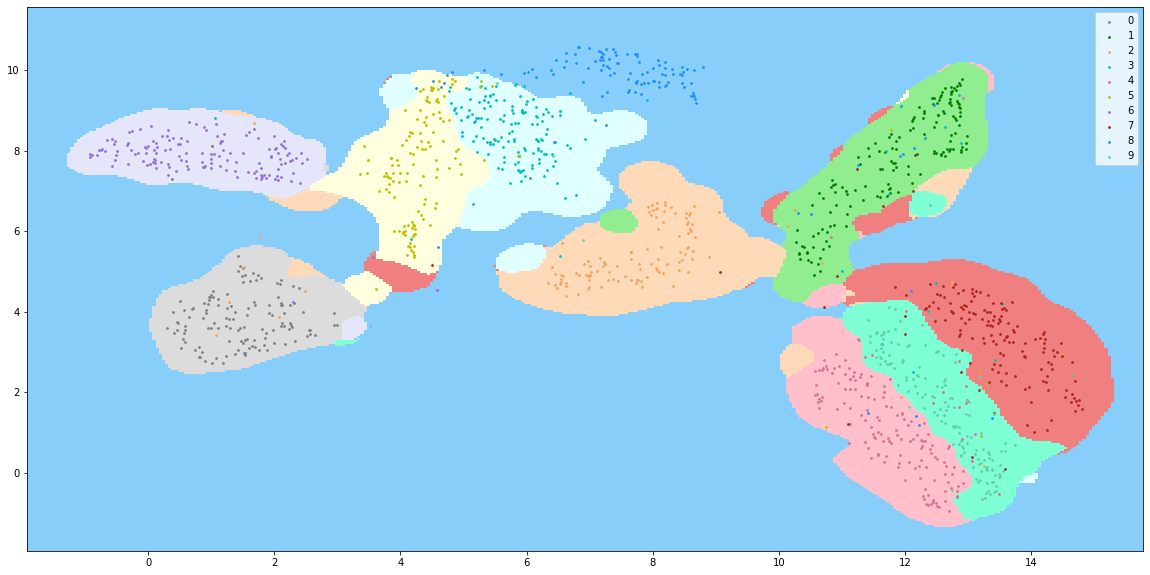

In [29]:
plot_decision_boundaries(clf_SVM, X_test_projection, y_test)

In [30]:
y_pred = clf_SVM.predict(X_test_projection)
accuracy_score(y_test, y_pred)

0.9107142857142857

In [31]:
confusion_matrix(y_test, y_pred)

array([[127,   0,   0,   0,   0,   0,   2,   0,   0,   0],
       [  0, 148,   0,   0,   0,   0,   0,   0,   0,   0],
       [  5,   3, 103,   0,   1,   0,   1,   5,   1,   2],
       [  0,   6,   1, 132,   0,   4,   1,   4,   5,   1],
       [  0,   2,   0,   0, 136,   0,   0,   0,   0,  18],
       [  0,   1,   0,   5,   1, 118,   0,   2,   0,   1],
       [  1,   0,   0,   0,   0,   0, 142,   1,   1,   0],
       [  0,   5,   1,   0,   2,   1,   0, 136,   0,   7],
       [  0,   9,   0,   5,   3,   5,   0,   1,  95,   2],
       [  0,   0,   1,   2,   2,   0,   0,   3,   1, 138]])

<div style="background-color: #EDF7FF; border-color: #7C9DBF; border-left: 5px solid #7C9DBF; padding: 0.5em;">
<strong>An√°lisis:</strong>
</div>

An√°lisis del ejercicio.

   - Comentar los resultados de la b√∫squeda de los mejores hiperpar√°metros.
   - ¬øC√≥mo son las fronteras de decisi√≥n? ¬øTiene sentido que tengan esta forma con el algoritmo utilizado?
   - ¬øC√≥mo son las predicciones obtenidas sobre el conjunto de test?

### 1.4. √Årboles de decisi√≥n

Los √°rboles de decisi√≥n son modelos predictivos formados por reglas binarias (si / no) con las que se consigue repartir las observaciones en funci√≥n de sus atributos y predecir as√≠ el valor de la variable respuesta.

Los √°rboles pueden ser **clasificadores** (para clasificar clases, tales como nuestro ejemplo), o bien **regresores** (para predecir variables continuas).

#### Construcci√≥n de un √°rbol

La creaci√≥n de las ramificaciones de los √°rboles se logra mediante el algoritmo de *recursive binary splitting*. Este algoritmo consta de tres pasos principales:

   - El proceso se inicia en lo alto del √°rbol, donde todas las observaciones pertenecen a la misma regi√≥n.
   - Se identifican todos los posibles puntos de corte para cada uno de los predictores. Los puntos de corte son cada uno de sus niveles.
   - se eval√∫an las posibles divisiones de cada predictor de acuerdo a una determinada medida. En el caso de los clasificadores se utilizan: *classification error rate*, Gini, entrop√≠a, chi-square.

#### Evitando el *overfitting*

El proceso de construcci√≥n de √°rboles descrito tiende a reducir r√°pidamente el error de entrenamiento, por lo que generalmente el modelo se ajusta muy bien a las observaciones utilizadas como entrenamiento (conjunto de *train*). Como consecuencia, los √°rboles de decisi√≥n tienden al *overfitting*. 

Para prevenirlo, utilizaremos dos hiperpar√°metros:

   - `max_depth`: la profundidad m√°xima del √°rbol. Exploraremos los valores entre 4 y 10.
   - `min_samples_split`: el n√∫mero m√≠nimo de observaciones que debe tener una hoja del √°rbol para poder dividir. Exploraremos los valores: 2, 10, 20, 50 y 100.

<div style="background-color: #EDF7FF; border-color: #7C9DBF; border-left: 5px solid #7C9DBF; padding: 0.5em;">
    <strong>Implementaci√≥n:</strong>
</div>

Calculad el valor √≥ptimo de los hiperpar√°metros `max_depth` y `min_samples_split`. Utilizad una b√∫squeda de rejilla con validaci√≥n cruzada para encontrar los valores √≥ptimos. Para cada combinaci√≥n de valores, calcular su promedio y la desviaci√≥n est√°ndar. Haced un _heatmap_ para visualizar la precisi√≥n seg√∫n los diferentes valores de los hiperpar√°metros.
    
P√≥deis utilizar el m√≥dulo `GridSearchCV` de `sklearn` el c√°lculo de los mejores hiperpar√°metros con el clasificador `DecisionTreeClassifier` (de `tree` de `sklearn`), y `heatmap` de `Seaborn`.

In [32]:
grid_params = {'max_depth':[4, 10],
              'min_samples_split':[2, 10, 20, 50, 100]}

gs_DecisionTree = GridSearchCV(
                    DecisionTreeClassifier(),
                    grid_params,
                    scoring='accuracy',
                    n_jobs=-1,
                    cv=4
                    )
gs_DecisionTree.fit(X_train_projection, y_train)
gs_DecisionTree.best_estimator_

DecisionTreeClassifier(max_depth=10, min_samples_split=20)

In [33]:
gs_DecisionTree.cv_results_['mean_test_score']

array([0.79375   , 0.79339286, 0.79339286, 0.79339286, 0.79339286,
       0.90928571, 0.90875   , 0.91517857, 0.90892857, 0.90214286])

In [34]:
gs_DecisionTree.cv_results_['std_test_score']

array([0.01687571, 0.01723469, 0.01723469, 0.01723469, 0.01723469,
       0.00327327, 0.0041149 , 0.0060688 , 0.00469748, 0.00679511])

In [35]:
pvt = pd.pivot_table(pd.DataFrame(gs_DecisionTree.cv_results_),
    values='mean_test_score', index='param_min_samples_split', columns='param_max_depth')

<AxesSubplot:xlabel='param_max_depth', ylabel='param_min_samples_split'>

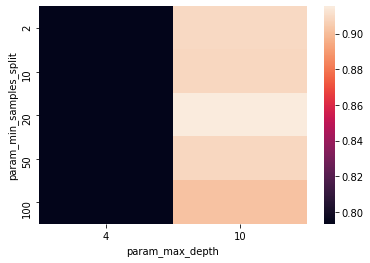

In [36]:
sns.heatmap(pvt)

<div style="background-color: #EDF7FF; border-color: #7C9DBF; border-left: 5px solid #7C9DBF; padding: 0.5em;">
<strong>Implementaci√≥n:</strong>
</div>

Con la mejor combinaci√≥n de hiperpar√°metros encontrados, entrenad un clasificador `DecisionTreeClassifier` (con `train`) y representar las fronteras de decisi√≥n con los puntos de `test`.
    
Calcular el _accuracy_ del modelo obtenido sobre _test_ y la matriz de confusi√≥n. Puede utilizar `accuracy_score` y `confusion_matrix` de `metrics` de `sklearn`.

In [37]:
gs_DecisionTree.best_estimator_.min_samples_split

20

In [38]:
clf_DecisionTree = DecisionTreeClassifier(max_depth=gs_DecisionTree.best_estimator_.max_depth, 
                                          min_samples_split=gs_DecisionTree.best_estimator_.min_samples_split)
clf_DecisionTree.fit(X_train_projection, y_train)

DecisionTreeClassifier(max_depth=10, min_samples_split=20)

<ipython-input-7-53494ca68afb>:23: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  plt.pcolormesh(xx, yy, Z, cmap=cmap_light)


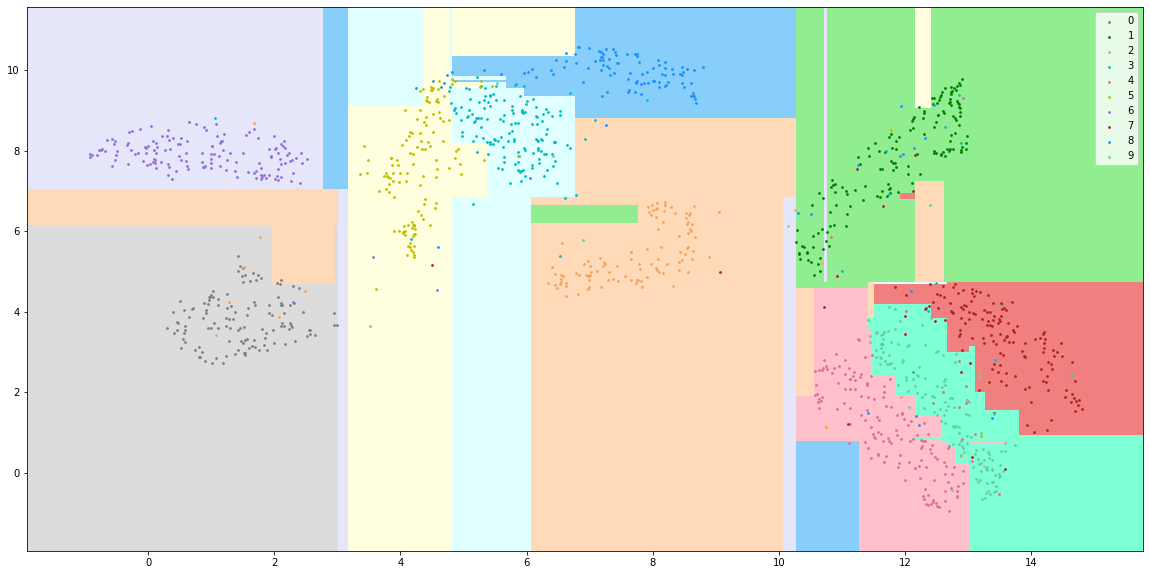

In [39]:
plot_decision_boundaries(clf_DecisionTree, X_test_projection, y_test)

In [40]:
y_pred = clf_DecisionTree.predict(X_test_projection)
accuracy_score(y_test, y_pred)

0.8942857142857142

In [41]:
confusion_matrix(y_test, y_pred)

array([[125,   0,   2,   0,   0,   0,   2,   0,   0,   0],
       [  0, 144,   0,   0,   2,   1,   0,   1,   0,   0],
       [  6,   2, 103,   0,   0,   0,   2,   5,   0,   3],
       [  0,   6,   5, 129,   0,   4,   1,   2,   5,   2],
       [  0,   2,   0,   0, 138,   0,   0,   0,   1,  15],
       [  1,   1,   0,   7,   1, 114,   0,   2,   1,   1],
       [  1,   0,   0,   0,   0,   2, 142,   0,   0,   0],
       [  0,   5,   2,   0,   2,   1,   0, 130,   0,  12],
       [  0,   9,   1,   6,   2,   5,   0,   1,  93,   3],
       [  0,   0,   2,   2,   5,   1,   0,   3,   0, 134]])

<div style="background-color: #EDF7FF; border-color: #7C9DBF; border-left: 5px solid #7C9DBF; padding: 0.5em;">
<strong>An√°lisis:</strong>
</div>

An√°lisis del ejercicio.

   - Comentar los resultados de la b√∫squeda de los mejores hiperpar√°metros.
   - ¬øC√≥mo son las fronteras de decisi√≥n? ¬øTiene sentido que tengan esta forma con el algoritmo utilizado?
   - ¬øC√≥mo son las predicciones obtenidas sobre el conjunto de test?

### 1.5. Mejorando los √°rboles de decisi√≥n

En la pr√°ctica, casi nunca se utiliza un solo √°rbol de decisi√≥n, sino que se combinan muchos √°rboles para obtener mejores resultados. Hay dos maneras de combinar √°rboles:

  - *__Bagging__*: utilizar el conjunto de entrenamiento original para generar centenar o miles de conjuntos similares utilizando muestreo con reemplazo. El algoritmo _random forest_ est√° basado en este concepto, la combinaci√≥n de varios √°rboles de decisi√≥n, cada uno entrenado con una muestra diferente de los datos. La decisi√≥n final del clasificador combinado (la _random forest_) se toma por mayor√≠a, dando el mismo peso a todas las decisiones parciales tomadas por los clasificadores base (los √°rboles).
  
  - *__Boosting__*: se combinan varios clasificadores d√©biles secuencialmente, y en cada uno de ellos se da m√°s peso a los datos que han sido err√≥neamente clasificadas en las combinaciones anteriores, para que se concentre as√≠ en los casos m√°s dif√≠ciles de resolver.
  
Ambos m√©todos los estudiaremos m√°s en detalle en la pr√≥xima PEC, pero en esta haremos un vistazo a los beneficios que nos aporta utilizar combinaciones de √°rboles respecto un solo √°rbol.

Al tratarse de √°rboles, sigue siendo importante optimizar `max_depth` y `min_samples_split`, pero en este caso a√±adiremos un hiperpar√°metro m√°s. Para simplificar, de los dos par√°metros anteriores optimizaremos s√≥lo `max_depth`:

  - `n_estimators`: n√∫mero de √°rboles. Exploraremos los valores: 50, 100 y 200.
  - `max_depth`: la profundidad m√°xima del √°rbol. Exploraremos los valores entre 8 y 12.

<div style="background-color: #EDF7FF; border-color: #7C9DBF; border-left: 5px solid #7C9DBF; padding: 0.5em;">
    <strong>Implementaci√≥n:</strong>
</div>

Escoged uno de los dos algoritmos mencionados: RandomForestClassifier o GradientBoostingClassifier. Calculad el valor √≥ptimo de los hiperpar√°metros `n_estimators` y `max_depth`. Utilizad una b√∫squeda de rejilla con validaci√≥n cruzada para encontrar los valores √≥ptimos. Para cada combinaci√≥n de valores, calcular su promedio y la desviaci√≥n est√°ndar. Haced un _heatmap_ para visualizar la precisi√≥n seg√∫n los diferentes valores de los hiperpar√°metros.
    
Pod√©is utilizar el m√≥dulo `GridSearchCV` de `sklearn` para el c√°lculo de los mejores hiperpar√°metros con el clasificador `RandomForestClassifier` o `GradientBoostingClassifier` (de `ensemble` de `sklearn`), y `heatmap` de `Seaborn`.
    
<u>Nota</u>: al utilizar tantos √°rboles, el _cross validation_ con todas las combinaciones de par√°metros es m√°s costosa que en los ejemplos anteriores, y por lo tanto tardar√° m√°s en ejecutarse.

In [42]:
grid_params = {'max_depth':[8, 12],
              'n_estimators':[50, 100, 200]}
gs_GBoostingCl = GridSearchCV(
                GradientBoostingClassifier(),
                grid_params,
                scoring='accuracy',
                n_jobs=-1,
                cv=4
                )
gs_GBoostingCl.fit(X_train_projection, y_train)
gs_GBoostingCl.best_estimator_

GradientBoostingClassifier(max_depth=8)

In [43]:
gs_GBoostingCl.cv_results_['mean_test_score']

array([0.91678571, 0.91785714, 0.91696429, 0.90642857, 0.91267857,
       0.91625   ])

In [44]:
gs_GBoostingCl.cv_results_['std_test_score']

array([0.00659507, 0.00460146, 0.00405243, 0.00683255, 0.00340224,
       0.00249361])

In [45]:
pvt = pd.pivot_table(pd.DataFrame(gs_GBoostingCl.cv_results_),
    values='mean_test_score', index='param_n_estimators', columns='param_max_depth')

<AxesSubplot:xlabel='param_max_depth', ylabel='param_n_estimators'>

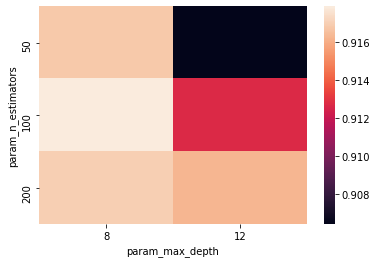

In [46]:
sns.heatmap(pvt)

<div style="background-color: #EDF7FF; border-color: #7C9DBF; border-left: 5px solid #7C9DBF; padding: 0.5em;">
<strong>Implementaci√≥n:</strong>
</div>

Con la mejor combinaci√≥n de hiperpar√°metros encontrada, entrenad un clasificador `DecisionTreeClassifier` (con _train_) y representar las fronteras de decisi√≥n con los puntos de test.
    
Calcular el _accuracy_ del modelo obtenido sobre test y la matriz de confusi√≥n. Puede utilizar `accuracy_score` y `confusion_matrix` de `metrics` de `sklearn`.

In [47]:
clf_GBoosting = GradientBoostingClassifier(max_depth=gs_GBoostingCl.best_estimator_.max_depth,
                                          n_estimators=gs_GBoostingCl.best_estimator_.n_estimators)
clf_GBoosting.fit(X_train_projection, y_train)

GradientBoostingClassifier(max_depth=8)

<ipython-input-7-53494ca68afb>:23: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  plt.pcolormesh(xx, yy, Z, cmap=cmap_light)


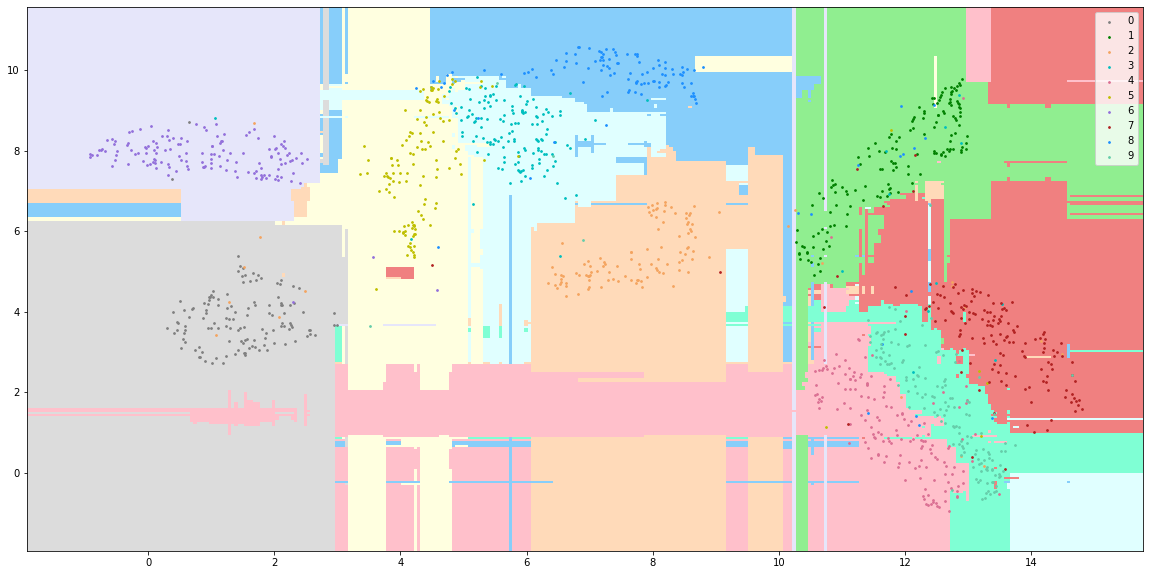

In [48]:
plot_decision_boundaries(clf_GBoosting, X_test_projection, y_test)

In [49]:
y_pred = clf_GBoosting.predict(X_test_projection)
accuracy_score(y_test, y_pred)

0.8964285714285715

In [50]:
confusion_matrix(y_test, y_pred)

array([[124,   0,   1,   0,   0,   0,   4,   0,   0,   0],
       [  0, 147,   0,   0,   0,   0,   0,   1,   0,   0],
       [  6,   2, 103,   0,   1,   0,   1,   5,   1,   2],
       [  0,   6,   1, 131,   0,   4,   1,   4,   6,   1],
       [  0,   1,   0,   0, 138,   0,   0,   1,   1,  15],
       [  0,   1,   0,   9,   2, 110,   0,   2,   4,   0],
       [  1,   0,   0,   0,   0,   2, 142,   0,   0,   0],
       [  0,   5,   1,   0,   2,   1,   0, 135,   0,   8],
       [  0,   9,   0,   5,   2,   6,   0,   1,  94,   3],
       [  0,   0,   1,   3,   6,   1,   0,   4,   1, 131]])

<div style="background-color: #EDF7FF; border-color: #7C9DBF; border-left: 5px solid #7C9DBF; padding: 0.5em;">
<strong>An√°lisis:</strong>
</div>

An√°lisis del ejercicio.

   - Comentar los resultados de la b√∫squeda de los mejores hiperpar√°metros.
   - ¬øC√≥mo son las fronteras de decisi√≥n? ¬øTiene sentido que tengan esta forma con el algoritmo utilizado?
   - ¬øC√≥mo son las predicciones obtenidas sobre el conjunto de test?
   - ¬øHa habido mejora respecto a utilizar un simple √°rbol de decisi√≥n?

# 2. Implementaci√≥n del caso pr√°ctico (5 puntos)

Para este ejercicio se proporciona un _dataset_ con datos sobre diferentes clientes de un banco que quieren comprar un piso, y si el banco les ha concedido la hipoteca o no. 

La informaci√≥n es la siguiente:

  - `ingresos`: los ingresos mensuales de la familia.
  - `gastos_comunes`: pagos mensuales de luz, agua, gas, etc.
  - `pago_coche`: si se est√° pagando cuota por uno o m√°s coches, y los gastos mensuales en combustible, etc.
  - `gastos_otros`: compra mensual en supermercado y lo necesario para vivir.
  - `ahorros`: suma de ahorros dispuestos a utilizar para la compra de la casa.
  - `vivienda`: precio de la vivienda que quiere comprar esta familia.
  - `estado_civil`: 0-soltero, 1-casados, 2-divorciados
  - `hijos`: cantidad de hijos menores y que no trabajan.
  - `trabajo`: 0-sin empleo, 1-aut√≥nomo (freelance), 2-empleado, 3-empresario, 4-pareja: aut√≥nomos, 5-pareja: empleados, 6-pareja: aut√≥nomo y asalariado, 7-pareja: empresario y aut√≥nomo , 8-pareja: empresarios los dos o empresario y empleado
  - `hipoteca`: 0-No ha sido concedida, 1-Si que ha sido concedida (esta ser√° nuestra columna de salida, para aprender)
  
Empezamos leyendo el _dataset_ y viendo una muestra de las primeras filas.

In [111]:
hipotecas = pd.read_csv("../data/hipotecas.csv")
hipotecas.head(10)

ingresos  gastos_comunes  pago_coche  gastos_otros  ahorros  vivienda  \
0      6000            1000           0           600    50000    400000   
1      6745             944         123           429    43240    636897   
2      6455            1033          98           795    57463    321779   
3      7098            1278          15           254    54506    660933   
4      6167             863         223           520    41512    348932   
5      5692             911          11           325    50875    360863   
6      6830            1298         345           309    46761    429812   
7      6470            1035          39           782    57439    606291   
8      6251            1250         209           571    50503    291010   
9      6987            1258         252           245    40611    324098   

   estado_civil  hijos  trabajo  hipoteca  
0             0      2        2         1  
1             1      3        6         0  
2             2      1        8         1  
3             0      0        3         0  
4             0      0        3         1  
5             1      4        5         1  
6             1      1        5         1  
7             0      0        1         0  
8             0      0        3         1  
9             2      1        7         1

### 2.1. An√°lisis descriptivo

Cuando se nos proporciona un _dataset_, antes de empezar a hacer nada, es muy importante hacer un an√°lisis exploratorio para conocer los datos con los que trabajaremos.

<div style="background-color: #EDF7FF; border-color: #7C9DBF; border-left: 5px solid #7C9DBF; padding: 0.5em;">
<strong>Implementaci√≥n:</strong> 
</div>

Calculad las frecuencias de la variable _target_ (`hipoteca`). Analizar la distribuci√≥n de las otras variables con gr√°ficos de barras las variables categ√≥ricas y con histogramas las variables num√©ricas.

In [112]:
hipotecas['hipoteca'].value_counts()

0    135
1     67
Name: hipoteca, dtype: int64

In [113]:
from scipy import stats
import random
import numpy as np
import plotly.express as px
import plotly.graph_objs as go
import plotly as py

In [114]:
def rand_web_color_hex():
    rgb = ""
    for _ in "RGB":
        i = random.randrange(0, 2 ** 8)
        rgb += i.to_bytes(1, "big").hex()
    return rgb

In [115]:
def generate_histogram_ploty(ds, name):
    fig = px.histogram(ds, x=name, color_discrete_sequence=['#' + rand_web_color_hex()],
                       labels=(dict(x=name.lower())), title="Histogram of " + name.lower())
    fig.show()

In [116]:
def generate_plots(ds):
    for col in ds:
        generate_histogram_ploty(ds, col)

In [117]:
generate_plots(hipotecas)

### 2.2. Preprocesamiento de los datos

Una vez hecho un primer an√°lisis, se trata de "limpiar" el dataset y adaptarlo a nuestras necesidades (en este caso, predecir si se conceder√° la hipoteca o no).

<div style="background-color: #EDF7FF; border-color: #7C9DBF; border-left: 5px solid #7C9DBF; padding: 0.5em;">
<strong>Implementaci√≥n:</strong>
</div>

Comprueba si hay valores `null`. En caso de haberlos, elimina las filas correspondientes.

In [118]:
hipotecas.isnull().sum()

ingresos          0
gastos_comunes    0
pago_coche        0
gastos_otros      0
ahorros           0
vivienda          0
estado_civil      0
hijos             0
trabajo           0
hipoteca          0
dtype: int64

<div style="background-color: #EDF7FF; border-color: #7C9DBF; border-left: 5px solid #7C9DBF; padding: 0.5em;">
<strong>Implementaci√≥n:</strong> 
</div>

- Agrupad los diversos gastos mensuales (`pago_coche` + `gastos_comunes` + `gastos_otros`) en una variable llamada `gastos`.
- Calculad el montante a financiar en una variable llamada `financiar`. Para ello crea una columna llamada `financiar` que ser√° el resto del precio de la vivienda con los ahorros de la familia.
- Elimina las variables utilizadas para crear estas nuevas columnas.

In [119]:
hipotecas['gastos'] = hipotecas.apply(lambda func: func.pago_coche + func.gastos_comunes + func.gastos_otros, axis=1)

In [120]:
hipotecas.head()[['pago_coche','gastos_comunes','gastos_otros','gastos']]

pago_coche  gastos_comunes  gastos_otros  gastos
0           0            1000           600    1600
1         123             944           429    1496
2          98            1033           795    1926
3          15            1278           254    1547
4         223             863           520    1606

In [121]:
hipotecas['financiar'] = hipotecas.apply(lambda func: func.vivienda - func.ahorros, axis=1)

In [122]:
hipotecas = hipotecas[['ingresos', 'estado_civil', 'hijos', 'trabajo', 'gastos','financiar','hipoteca']]

In [123]:
hipotecas.head()

ingresos  estado_civil  hijos  trabajo  gastos  financiar  hipoteca
0      6000             0      2        2    1600     350000         1
1      6745             1      3        6    1496     593657         0
2      6455             2      1        8    1926     264316         1
3      7098             0      0        3    1547     606427         0
4      6167             0      0        3    1606     307420         1

El siguiente paso ser√≠a ver la correlaci√≥n entre todas las _features_ num√©ricas. Esto se hace para asegurar que no hay dos variables muy relacionadas entre s√≠, ya que en tal caso se deber√≠a seleccionar una de las dos o combinarlas en una nueva.

<div style="background-color: #EDF7FF; border-color: #7C9DBF; border-left: 5px solid #7C9DBF; padding: 0.5em;">
<strong>Implementaci√≥n:</strong>
</div>

Mostrad la correlaci√≥n entre todas las _features_ num√©ricas. Si hay dos con una correlaci√≥n superior al 80%, eliminar una de las dos.
    
Pod√©is utilizar `heatmap` de `Seaborn`, para verlas en un mapa de colores.

In [124]:
hipotecas_numeric = hipotecas[['ingresos','gastos','financiar']]

In [125]:
hipotecas_corr = hipotecas_numeric.corr(method='pearson')

In [126]:
hipotecas_corr

ingresos    gastos  financiar
ingresos   1.000000  0.362823   0.564351
gastos     0.362823  1.000000   0.105849
financiar  0.564351  0.105849   1.000000

<AxesSubplot:>

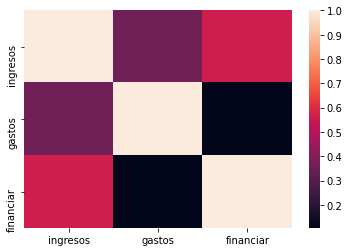

In [127]:
sns.heatmap(hipotecas_corr)

Ya tenemos las variables finales con las que trabajaremos. Vamos a observar ahora cu√°l es la relaci√≥n de cada una de ellas con el `target`.

<div style="background-color: #EDF7FF; border-color: #7C9DBF; border-left: 5px solid #7C9DBF; padding: 0.5em;">
<strong>Implementaci√≥n:</strong>
</div>

Repite los diagramas de barras y los histogramas, separando por colores la variable _target_ (dentro del mismo gr√°fico, diferenciar entre hipoteca-s√≠ y hipoteca-no).
    
<u>Nota</u>: Puedes utilizar el par√°metro `alpha` para que se vean los dos gr√°ficos a la vez.

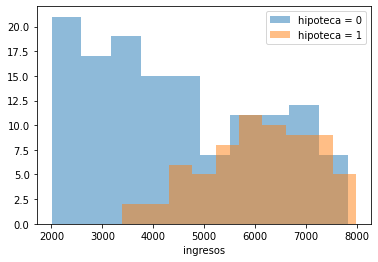

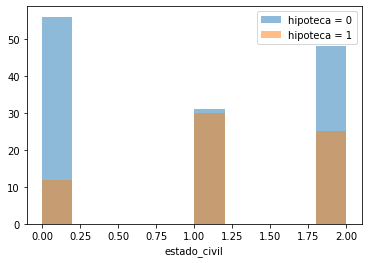

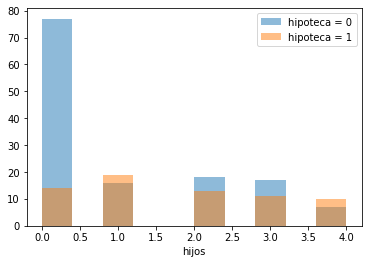

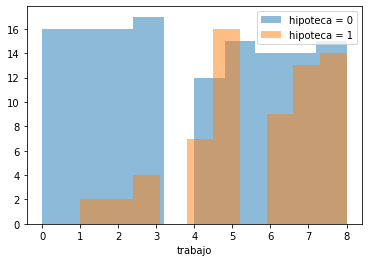

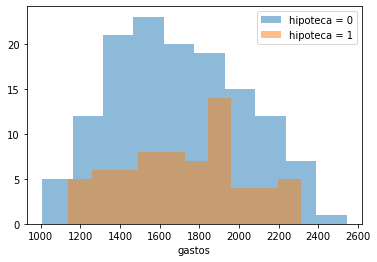

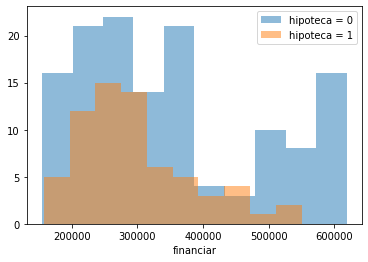

In [128]:
for col in hipotecas:
    if col != 'hipoteca':
        plt.hist(hipotecas[hipotecas['hipoteca'] == 0][col], label ='hipoteca = 0', alpha=0.5)
        plt.hist(hipotecas[hipotecas['hipoteca'] == 1][col], label ='hipoteca = 1', alpha=0.5)
        plt.legend(loc='upper right')
        plt.xlabel(col)
        plt.show()

**Conclusiones obtenidas:**

* ingresos -> influye
* estado_civil -> influye
* hijos -> influye (parece que a mayor n√∫mero de hijos, m√°s hipotecas se dan)
* trabajo -> influye
* gastos -> influye
* financiar -> influye

Finalmente, s√≥lo nos queda pasar las variables categ√≥ricas a num√©ricas. Observad que a pesar de que todas las variables tengan n√∫meros, esto no quiere decir que sean num√©ricas. Por ejemplo, la variable `estado_civil` tiene los valores 0-1-2, que ser√≠a lo mismo que si tuviera los valores soltero-casado-divorciado. Hay otras variables donde esto no ocurre, por ejemplo el n√∫mero de hijos, que a pesar de ser categ√≥rica s√≠ que son n√∫meros, ya que es ordinal. La manera de diferenciarlo es, en el caso del n√∫mero de hijos, 1 hijo es menos que 2 hijos, mientras que con el estado civil no hay un orden.

Una manera de pasar las variables categ√≥ricas en num√©ricas es aplicando _one-hot encoding_. Por ejemplo, en el caso de la variable `estado_civil`, lo que se har√≠a ser√≠a crear tres columnas nuevas: `soltero`, `casado` y `divorciado`. Estas columnas tendr√≠an los valores 0-1, por ejemplo, en el caso de la columna `soltero` tendr√≠a el valor 1 cuando `estado_civil = soltero`, y cero en otro caso.

<div style="background-color: #EDF7FF; border-color: #7C9DBF; border-left: 5px solid #7C9DBF; padding: 0.5em;">
<strong>Implementaci√≥n:</strong>
</div>

Aplica _one-hot-encoding_ a las variables categ√≥ricas que lo requieran. No olvid√©is eliminar las variables originales!
    
Pod√©is utilizar `OneHotEncoder` de `sklearn.preprocessing`.

In [129]:
hipotecas

ingresos  estado_civil  hijos  trabajo  gastos  financiar  hipoteca
0        6000             0      2        2    1600     350000         1
1        6745             1      3        6    1496     593657         0
2        6455             2      1        8    1926     264316         1
3        7098             0      0        3    1547     606427         0
4        6167             0      0        3    1606     307420         1
..        ...           ...    ...      ...     ...        ...       ...
197      3831             0      0        2    1530     352397         0
198      3961             2      3        8    1775     258541         0
199      3184             1      3        8    1915     352460         0
200      3334             1      2        5    1888     356907         0
201      3988             0      0        4    1644     245600         0

[202 rows x 7 columns]

In [130]:
def change_estado_civil(n):
    if n == 0:
        return 'soltero'
    elif n== 1:
        return 'casados'
    elif n== 2:
        return 'divorciados'

In [131]:
hipotecas['estado_civil'].value_counts()

2    73
0    68
1    61
Name: estado_civil, dtype: int64

In [132]:
hipotecas['estado_civil'] = hipotecas['estado_civil'].apply(lambda func: 
                                                            change_estado_civil(func))

In [133]:
hipotecas['estado_civil'].value_counts()

divorciados    73
soltero        68
casados        61
Name: estado_civil, dtype: int64

In [134]:
hipotecas['trabajo'].value_counts()

5    31
8    29
7    27
6    23
3    21
4    19
2    18
1    18
0    16
Name: trabajo, dtype: int64

In [135]:
def change_trabajo(n):
    if n == 0:
        return 'sin_empleo'
    elif n == 1:
        return 'autonomo'
    elif n== 2:
        return 'empleado'
    elif n== 3:
        return 'empresario'
    elif n== 4:
        return 'autonomos'
    elif n== 5:
        return 'empleados_dos'
    elif n== 6:
        return 'autonomo_y_asalariado'
    elif n== 7:
        return 'empresario_y_autonomo'
    elif n== 8:
        return 'empresario_y_empleado_o_empresarios'

In [136]:
hipotecas['trabajo'] = hipotecas['trabajo'].apply(lambda func: 
                                                            change_trabajo(func))

In [137]:
hipotecas['trabajo'].value_counts()

empleados_dos                          31
empresario_y_empleado_o_empresarios    29
empresario_y_autonomo                  27
autonomo_y_asalariado                  23
empresario                             21
autonomos                              19
autonomo                               18
empleado                               18
sin_empleo                             16
Name: trabajo, dtype: int64

In [141]:
hipotecas_one_hot = pd.get_dummies(data=hipotecas, columns=['trabajo','estado_civil'])

In [143]:
hipotecas_one_hot.head()

ingresos  hijos  gastos  financiar  hipoteca  trabajo_autonomo  \
0      6000      2    1600     350000         1                 0   
1      6745      3    1496     593657         0                 0   
2      6455      1    1926     264316         1                 0   
3      7098      0    1547     606427         0                 0   
4      6167      0    1606     307420         1                 0   

   trabajo_autonomo_y_asalariado  trabajo_autonomos  trabajo_empleado  \
0                              0                  0                 1   
1                              1                  0                 0   
2                              0                  0                 0   
3                              0                  0                 0   
4                              0                  0                 0   

   trabajo_empleados_dos  trabajo_empresario  trabajo_empresario_y_autonomo  \
0                      0                   0                              0   
1                      0                   0                              0   
2                      0                   0                              0   
3                      0                   1                              0   
4                      0                   1                              0   

   trabajo_empresario_y_empleado_o_empresarios  trabajo_sin_empleo  \
0                                            0                   0   
1                                            0                   0   
2                                            1                   0   
3                                            0                   0   
4                                            0                   0   

   estado_civil_casados  estado_civil_divorciados  estado_civil_soltero  
0                     0                         0                     1  
1                     1                         0                     0  
2                     0                         1                     0  
3                     0                         0                     1  
4                     0                         0                     1

<div style="background-color: #EDF7FF; border-color: #7C9DBF; border-left: 5px solid #7C9DBF; padding: 0.5em;">
<strong>An√°lisis:</strong>
</div>

- ¬øPor qu√© es necesario hacer _one-hot encoding_? 
- ¬øQu√© diferencia hay entre tener una columna `estado_civil` o tres columnas `soltero`, `casado` y `divorciado` si la informaci√≥n es la misma? 
- ¬øPor qu√© es incorrecto a nivel conceptual dejar las variables tal y como las ten√≠amos, si eran n√∫meros y el modelo hubiera funcionado?


### 2.3. Entrenamiento de un modelo

Ahora que ya tenemos el _dataset_ limpio y hemos hecho un an√°lisis de las diferentes variables, podemos proceder a entrenar un modelo para predecir si se concede una hipoteca o no. 

Probaremos con 2 modelos diferentes e interpretaremos los resultados. 

Para empezar, separamos el dataset entre _train_ y _test_.

<div style="background-color: #EDF7FF; border-color: #7C9DBF; border-left: 5px solid #7C9DBF; padding: 0.5em;">
    <strong>Implementaci√≥n:</strong> 
</div>

Dividid el _dataset_ en dos subconjuntos: _train_ (80% de los datos) y _test_ (20% de los datos). Nombrad los conjuntos: X_train, X_test, y_train, y_test. Utilizad la opci√≥n `random_state = 24`.
    
Pod√©is utilizar la implementaci√≥n `train_test_split` de `sklearn`.

In [148]:
X = hipotecas_one_hot.drop(['hipoteca'], axis=1)
y = hipotecas[['hipoteca']]

In [149]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=24)

<div style="background-color: #EDF7FF; border-color: #7C9DBF; border-left: 5px solid #7C9DBF; padding: 0.5em;">
<strong>Implementaci√≥n:</strong>
</div>

Utilizad un √°rbol de decisi√≥n simple con `max_depth = 5` para acotar el dataset "hipotecas" sobre el conjunto de _train_. Dibujad el √°rbol de decisi√≥n. Calculad el _accuray_ y la matriz de confusi√≥n sobre _train_ y sobre _test_.
    
Para dibujar el √°rbol, pod√©is guiaros con este enlace: https://towardsdatascience.com/visualizing-decision-trees-with-python-scikit-learn-graphviz-matplotlib-1c50b4aa68dc

In [150]:
clf_DecisionTree = DecisionTreeClassifier(max_depth=5)
clf_DecisionTree.fit(X_train, y_train)

DecisionTreeClassifier(max_depth=5)

In [158]:
from sklearn import tree
import graphviz


In [169]:
y_train['hipoteca'].unique()

array([0, 1])

In [171]:
tree.export_graphviz(clf_DecisionTree,
                     out_file="tree_1.dot",
                     feature_names = X_train.columns, 
                     class_names=['No','Yes'],
                     filled = True)

In [184]:
import matplotlib.image as mpimg

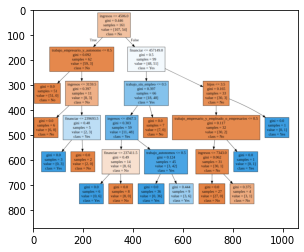

In [185]:
plt.imshow(mpimg.imread('./tree_1.png'))

![tree_1](tree_1.png)


In [151]:
y_pred = clf_DecisionTree.predict(X_test)

In [152]:
accuracy_score(y_test, y_pred)

0.8048780487804879

In [153]:
confusion_matrix(y_test, y_pred)

array([[22,  6],
       [ 2, 11]])

<div style="background-color: #EDF7FF; border-color: #7C9DBF; border-left: 5px solid #7C9DBF; padding: 0.5em;">
<strong>An√°lisis:</strong> 
</div>

Interpretad el √°rbol de decisi√≥n:

- ¬øCu√°les son las variables que han tenido m√°s peso? 
- ¬øHas obtenido una buena precisi√≥n evaluando en test? 
- ¬øSe ha producido _overfitting_?

<div style="background-color: #EDF7FF; border-color: #7C9DBF; border-left: 5px solid #7C9DBF; padding: 0.5em;">
<strong>Implementaci√≥n:</strong>
</div>

Usad _Random Forest_ o _Gradient Boosting_ para acotar el _dataset_ "hipotecas". Esta vez vamos a optimizar el modelo para obtener los mejores resultados posibles. Tal y como hemos visto en el ejercicio anterior, recuerda seguir los siguientes pasos:
    
   - Utilizar el _dataset_ de _train_ para encontrar los mejores hiperpar√°metros haciendo _cross-validation_.
   - Entrenar el modelo con _train_, predecir con test y calcular su _accuracy_ y la matriz de confusi√≥n.

In [186]:
grid_params = {'max_depth':[8, 12],
              'n_estimators':[50, 100, 200]}
gs_RndForestCl = GridSearchCV(
                RandomForestClassifier(),
                grid_params,
                scoring='accuracy',
                n_jobs=-1,
                cv=4
                )
gs_RndForestCl.fit(X_train, y_train)
gs_RndForestCl.best_estimator_

/home/fran/.local/lib/python3.8/site-packages/sklearn/model_selection/_search.py:880: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().



RandomForestClassifier(max_depth=12, n_estimators=200)

In [187]:
clf_RndForest = RandomForestClassifier(max_depth=gs_RndForestCl.best_estimator_.max_depth,
                                          n_estimators=gs_RndForestCl.best_estimator_.n_estimators)
clf_RndForest.fit(X_train, y_train)

<ipython-input-187-a26b53791e63>:3: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().



RandomForestClassifier(max_depth=12, n_estimators=200)

In [189]:
y_pred = clf_RndForest.predict(X_test)
accuracy_score(y_test, y_pred)

0.9024390243902439

In [190]:
confusion_matrix(y_test, y_pred)

array([[27,  1],
       [ 3, 10]])

Un _Random Forest_ / _Gradient Boosting_ no es tan f√°cil de interpretar como un simple _Decision Tree_. No podemos dibujar el √°rbol, porque son combinaciones de muchos √°rboles, pero si que podemos saber cu√°les han sido las variables m√°s decisivas a la hora de generar el modelo. Para saberlo, no podemos hacerlo a ojo mirando c√≥mo se divide el √°rbol, sino que lo podemos consultar al modelo mediante la _feature importance_ de este.

<div style="background-color: #EDF7FF; border-color: #7C9DBF; border-left: 5px solid #7C9DBF; padding: 0.5em;">
<strong>Implementaci√≥n:</strong>
</div>

Muestra cada variable del modelo fitado, junto con su _feature importance_.

In [192]:
clf_RndForest.feature_importances_

array([0.3764709 , 0.10401171, 0.10466061, 0.23305843, 0.00666601,
       0.00857597, 0.01047637, 0.00492344, 0.018803  , 0.00883827,
       0.01606126, 0.0134642 , 0.02988879, 0.01769719, 0.01630452,
       0.03009934])

<BarContainer object of 16 artists>

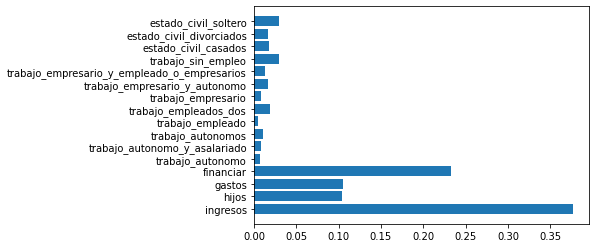

In [194]:
plt.barh(X.columns, clf_RndForest.feature_importances_)


<div style="background-color: #EDF7FF; border-color: #7C9DBF; border-left: 5px solid #7C9DBF; padding: 0.5em;">
<strong>An√°lisis:</strong> 
</div>

Interpreta el clasificador:

- ¬øCu√°les son las variables que han tenido m√°s peso? 
- ¬øHas obtenido una buena precisi√≥n evaluando en test? 
- ¬øSe ha producido _overfitting_?

### 2.4. Predicci√≥n de nuevos casos

Hasta ahora hemos entrenado un modelo y hemos evaluado en test para hacernos una idea de la precisi√≥n de nuestro modelo con datos reales. Ahora vamos a utilizarlo.

<div style="background-color: #EDF7FF; border-color: #7C9DBF; border-left: 5px solid #7C9DBF; padding: 0.5em;">
<strong>Implementaci√≥n:</strong>
</div>

Suponed que trabaj√°is en un banco y os visitan clientes que quieren una hipoteca. Aunque se ha de realizar un estudio a fondo de cada caso, as√≠ _a priori_ utilizad el clasificador entrenado para tener una idea de si se les conceder√° la hipoteca o no.
    
   - Caso 1: Familia con unos ingresos de 2.000 ‚Ç¨ y unos gastos de 500 ‚Ç¨, la pareja son empresarios y no tienen hijos. Necesitar√≠an para tener la casa de sus sue√±os una financiaci√≥n de 200.000 ‚Ç¨.
   - Caso 2: Familia con unos ingresos de 6.000 ‚Ç¨ y unos gastos de 3.400 ‚Ç¨, la pareja uno es asalariado y el otro aut√≥nomo con dos hijos a su cargo. Necesitar√≠an para tener la casa de sus sue√±os una financiaci√≥n de 320.000 ‚Ç¨.
   - Caso 3: Una mujer soltera con unos ingresos de 9.000 ‚Ç¨ y unos gastos de 2.250 ‚Ç¨, con un hijo a su cargo y de profesi√≥n aut√≥noma. Necesitar√≠a una financiaci√≥n de 39.000 ‚Ç¨.

In [201]:
data_to_predict = pd.DataFrame(columns=X_test.columns)

In [202]:
data_to_predict.columns

Index(['ingresos', 'hijos', 'gastos', 'financiar', 'trabajo_autonomo',
       'trabajo_autonomo_y_asalariado', 'trabajo_autonomos',
       'trabajo_empleado', 'trabajo_empleados_dos', 'trabajo_empresario',
       'trabajo_empresario_y_autonomo',
       'trabajo_empresario_y_empleado_o_empresarios', 'trabajo_sin_empleo',
       'estado_civil_casados', 'estado_civil_divorciados',
       'estado_civil_soltero'],
      dtype='object')

In [212]:
case1 = pd.DataFrame([[2000, 0, 500, 200000, 0,0,0,0,0,0,0,0,0,0,0,0],], columns=X_test.columns)
case1['trabajo_empresario_y_empleado_o_empresarios'] = 1
case1['estado_civil_casados'] = 1

In [214]:
case2 = pd.DataFrame([[6000, 2, 3400, 320000, 0,0,0,0,0,0,0,0,0,0,0,0],], columns=X_test.columns)
case2['trabajo_autonomo_y_asalariado'] = 1
case2['estado_civil_casados'] = 1

In [215]:
case3 = pd.DataFrame([[9000, 1, 2250, 39000, 0,0,0,0,0,0,0,0,0,0,0,0],], columns=X_test.columns)
case3['trabajo_autonomo'] = 1
case3['estado_civil_soltero'] = 1

In [216]:
clf_RndForest.predict(case1)

array([0])

In [219]:
clf_RndForest.predict_proba(case1)

array([[0.92, 0.08]])

In [217]:
clf_RndForest.predict(case2)

array([1])

In [220]:
clf_RndForest.predict_proba(case2)

array([[0.232, 0.768]])

In [218]:
clf_RndForest.predict(case3)

array([1])

In [221]:
clf_RndForest.predict_proba(case3)

array([[0.265, 0.735]])